In [ ]:
from torch.nn import functional as F

import sys
sys.path.append("../training_scripts")
from models.classifiers.simple_classifier import SimpleClassifier
from models.VAE import vae_models
from data.dataset_lit import DatasetLit
from torcheval.metrics import MulticlassAccuracy, MulticlassAUROC

from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
from torchvision.utils import make_grid

import torch
from torchdyn.core import NeuralODE
from torchcfm.conditional_flow_matching import ConditionalFlowMatcher
from torchcfm.utils import *

from multiprocessing import Pool
import pandas as pd
from pathlib import Path

In [2]:
# configs
device = 'cuda'
Path("./checkpoints").mkdir(parents=True, exist_ok=True)

## Build dataset

In [4]:
dataset = DatasetLit(name = 'MorphoMNIST', image_size = 28, 
                     train_batch_size = 256, val_batch_size = 512, test_batch_size = 512,
                     num_workers = 8, pin_memory = False, download = False,
                     root = './morphoMNIST_data'
                    )
dataset.setup()

## Build and train classifier

In [4]:
# Configs
lr = 1e-2
n_epochs = 10
loss_func = torch.nn.CrossEntropyLoss()

# Build the classifier
classifier = SimpleClassifier(10).to(device)
# Try to load the weights
try:
    classifier.load_state_dict(torch.load('checkpoints/morpho_classifier_weights.pt', weights_only=True))
# Training loop
except:
    classifier.train()
    optimizer = torch.optim.Adam(classifier.parameters(), lr = lr)
    pbar = tqdm(range(n_epochs))
    for epoch in pbar:
        for img, label in dataset.train_dataloader():
            img = img.to(device)
            label = label.to(device)
            pred = classifier(img)
            loss = loss_func(pred, label)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        pbar.set_description("Epoch {:03d}: Loss = {:.3f}".format(epoch + 1, loss.detach()))
    torch.save(classifier.state_dict(), 'checkpoints/morpho_classifier_weights.pt')

In [5]:
# evaluate the classifier
classifier.eval()
metric = MulticlassAccuracy()
for test_img, test_label in dataset.test_dataloader():
    test_img = test_img.to(device)
    test_label = test_label.to(device)
    pred = classifier(test_img)
    metric.update(pred, test_label)
acc = metric.compute()
print('The accuracy is {:.3f}%'.format(acc * 100.))

The accuracy is 97.070%


## Build and train cVAE

In [6]:
# Configs
lr = 5e-3
n_epochs = 100
kld_weight = 0.00025

cvae = vae_models['Simple_VAE'](in_channels = 1, latent_dim = 32, num_classes = 10).to(device)
# Try to load the weights
try:
    cvae.load_state_dict(torch.load('checkpoints/morpho_cvae_weights.pt', weights_only=True))
# Training loop
except:
    cvae.train()
    optimizer = torch.optim.Adam(cvae.parameters(), lr = lr)
    pbar = tqdm(range(n_epochs))
    for epoch in pbar:
        for img, _ in dataset.train_dataloader():
            img = img.to(device)
            label_pred = F.softmax(classifier(img), dim = 1)
            results = cvae(img, cond = label_pred)
            losses = cvae.loss_function(*results, kld_weight = kld_weight)
            loss = losses['loss']
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        pbar.set_description("Epoch {:03d}: Loss = {:.3f}, Recon_loss = {:.3f}, KLD = {:.3f}".format(epoch + 1, loss.detach(), losses['Reconstruction_Loss'].detach(), losses['KLD'].detach()))
    torch.save(cvae.state_dict(), 'checkpoints/morpho_cvae_weights.pt')

In [ ]:
# Check the reconstruction performance
cvae.eval()
num_img = 10
test_img, _ = next(iter(dataset.test_dataloader()))
test_img = test_img[:num_img].to(device)
test_label_pred = F.softmax(classifier(test_img), dim = 1)
test_results = cvae(test_img, cond = test_label_pred)
toshow = torch.cat(test_results[:2], dim = 0)
grid = make_grid(toshow, nrow = num_img)
img = ToPILImage()(grid)
plt.imshow(img)
plt.gca().set_axis_off()
plt.show()

## Build and train VAE

In [ ]:
# Configs
lr = 5e-3
n_epochs = 100
kld_weight = 0.00025

vae = vae_models['Simple_VAE'](in_channels = 1, latent_dim = 32, num_classes = 0).to(device)
# Try to load the weights
try:
    vae.load_state_dict(torch.load('checkpoints/morpho_vae_weights.pt', weights_only=True))
# Training loop
except:
    vae.train()
    optimizer = torch.optim.Adam(vae.parameters(), lr = lr)
    pbar = tqdm(range(n_epochs))
    for epoch in pbar:
        for img, _ in dataset.train_dataloader():
            img = img.to(device)
            results = vae(img, cond = None)
            losses = vae.loss_function(*results, kld_weight = kld_weight)
            loss = losses['loss']
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        pbar.set_description("Epoch {:03d}: Loss = {:.3f}, Recon_loss = {:.3f}, KLD = {:.3f}".format(epoch + 1, loss.detach(), losses['Reconstruction_Loss'].detach(), losses['KLD'].detach()))
    torch.save(vae.state_dict(), 'checkpoints/morpho_vae_weights.pt')

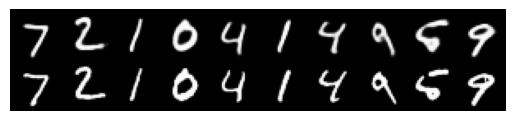

In [9]:
# Check the reconstruction performance
vae.eval()
num_img = 10
test_img, _ = next(iter(dataset.test_dataloader()))
test_img = test_img[:num_img].to(device)
test_results = vae(test_img, cond = None)
toshow = torch.cat(test_results[:2], dim = 0)
grid = make_grid(toshow, nrow = num_img)
img = ToPILImage()(grid)
plt.imshow(img)
plt.gca().set_axis_off()
plt.show()

## Build and train Flows

In [10]:
class MLP_CFM(torch.nn.Module):
    def __init__(self, dim, out_dim=None, w=64, time_varying=False, cond=False, cond_dim = None):
        super().__init__()
        self.time_varying = time_varying
        if out_dim is None:
            out_dim = dim
        if cond and cond_dim is None:
            cond_dim = dim
        self.net = torch.nn.Sequential(
            torch.nn.Linear(dim + (1 if time_varying else 0) + (cond_dim if cond else 0), w),
            torch.nn.SELU(),
            torch.nn.Linear(w, w),
            torch.nn.SELU(),
            torch.nn.Linear(w, w),
            torch.nn.SELU(),
            torch.nn.Linear(w, out_dim),
        )

    def forward(self, t, x):
        while t.dim() > 1:
            t = t[:, 0]
        if t.dim() == 0:
            t = t[:, None]
        if t.dim() == 1 and t.shape[0] == 1:
            t = t.repeat(x.shape[0])
        return self.net(torch.cat([x, t[:, None]], dim = 1))

In [11]:
sigma = 0.
dim = 32
batch_size = 256
n_epochs = 30
lr = 0.005

model_cfm = MLP_CFM(dim=dim, time_varying=True, cond=True, cond_dim = 10).to(device)
# Try to load the weights
try:
    model_cfm.load_state_dict(torch.load('checkpoints/morpho_flow_weights.pt', weights_only=True))
# Training loop
except:
    optimizer = torch.optim.Adam(model_cfm.parameters(), lr = lr)
    FM = ConditionalFlowMatcher(sigma=sigma)
    pbar = tqdm(range(n_epochs))
    model_cfm.train()
    for epoch in pbar:
        for img, label in dataset.train_dataloader():
            x1, _ = vae.encode(img.to(device))
            y = F.softmax(classifier(img.to(device)), dim = 1)
            x0 = torch.randn_like(x1)
            t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)
            vt = model_cfm(t, torch.cat([xt, y], dim=-1))
            loss = torch.mean((vt - ut) ** 2)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        pbar.set_description("Epoch {:03d}: Loss = {:.3f}".format(epoch + 1, loss.item()))
    torch.save(model_cfm.state_dict(), 'checkpoints/morpho_flow_weights.pt')
model_cfm.eval()

Epoch 030: Loss = 0.930: 100%|████████████████████████████████████████████████████████████████| 30/30 [01:08<00:00,  2.27s/it]


MLP_CFM(
  (net): Sequential(
    (0): Linear(in_features=43, out_features=64, bias=True)
    (1): SELU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): SELU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): SELU()
    (6): Linear(in_features=64, out_features=32, bias=True)
  )
)

In [12]:
class torch_wrapper(torch.nn.Module):
    """Wraps model to torchdyn compatible format."""
    def __init__(self, model, c, step_size= 1.):
        super().__init__()
        self.model = model
        self.c = c
        self.step_size = step_size

    def forward(self, t, x, *args, **kwargs):
        if t.dim() == 0: t = t.unsqueeze(0)
        return self.step_size * self.model(t, torch.cat([x, self.c], dim=-1))
        
@torch.no_grad()
def leap(model, source_points, source_y, target_y, gamma = 1., n_steps = 10, t_lower = 0., t_upper = 1., mode='blending'):
    if mode == 'blending':
        node_lift = NeuralODE(torch_wrapper(model, source_y, gamma), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)
        # lifting transport
        traj_lift = node_lift.trajectory(
            source_points,
            t_span=torch.linspace(t_upper, t_lower, n_steps),
        )
    land_start_points = traj_lift[-1].detach().clone() if mode == 'blending' else source_points
    node_land = NeuralODE(torch_wrapper(model, target_y, gamma), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)
    # landing transport
    traj_land = node_land.trajectory(
            land_start_points,
            t_span=torch.linspace(t_lower, t_upper, n_steps),
        )
    return traj_land

@torch.no_grad()
def progressive_leap(model, source_points, classifier, generator, target_y, gamma = 0.1, max_itr = 10, n_steps = 10, t_lower = 0., t_upper = 1., mode='blending', mute = False):
    assert mode in ['blending', 'injection']
    traj_list = []
    lift_start_points = source_points
    for itr in range(max_itr):
        source_y = classifier(generator(lift_start_points))
        if not mute: print('Processing itration {:03d}, predicted label {}'.format(itr, torch.argmax(source_y, dim = 1 ).detach().cpu().numpy()), end = '\r')
        traj_land = leap(model, lift_start_points, source_y, target_y,
                            gamma = gamma, n_steps = n_steps, t_lower = t_lower, t_upper=t_upper,
                            mode = mode)
        lift_start_points = traj_land[-1]
        traj_list.append(lift_start_points)
    return traj_list

### Information Blending

In [13]:
gamma = 0.1
max_itr = 15
n_steps = 5
mode = 'blending'

In [ ]:
# Check the reconstruction performance
model_cfm.eval()
num_img = 10
test_img, _ = next(iter(dataset.test_dataloader()))
test_img = test_img[:num_img].to(device)
source_points, _ = vae.encode(test_img, cond = None)
target_y = F.one_hot(torch.arange(10, device=device), 10)
generator = lambda x: vae.decode(x, cond = None)
traj_list = progressive_leap(model_cfm, source_points, lambda x: F.softmax(classifier(x)), generator, target_y,
                gamma = gamma, max_itr = max_itr, n_steps = n_steps, mode = mode
                )
cf_imgs = vae.decode(traj_list[-1])

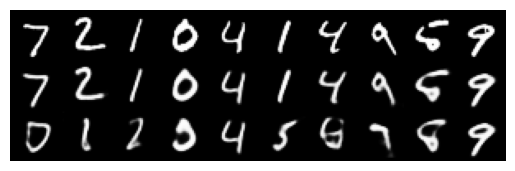

In [15]:
grid = make_grid(
    torch.cat([
        test_img,
        vae.decode(source_points),
        vae.decode(traj_list[-1])
    ], dim = 0), 
    nrow=10
)
img = ToPILImage()(grid)
plt.imshow(img)
plt.gca().set_axis_off()
plt.show()

### Information Injection

In [16]:
gamma = 0.1
max_itr = 5
n_steps = 5
mode = 'injection'

In [ ]:
source_points_robust = traj_list[-1]
target_y = F.one_hot(torch.arange(10, device=device), 10)
generator = lambda x: vae.decode(x, cond = None)
traj_list_robust = progressive_leap(model_cfm, source_points_robust, lambda x: F.softmax(classifier(x)), generator, target_y,
                gamma = gamma, max_itr = max_itr, n_steps = n_steps, mode = mode
                )
cf_robust_imgs = vae.decode(traj_list_robust[-1])

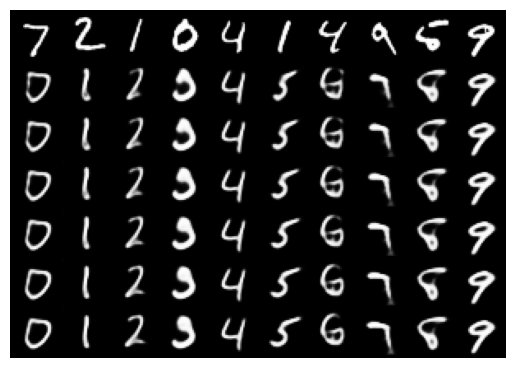

In [18]:
img_list = [test_img, vae.decode(source_points_robust)]
for traj_robust in traj_list_robust:
    img_list.append(vae.decode(traj_robust))
grid = make_grid(
    torch.cat(img_list, dim = 0), 
    nrow=10
)
img = ToPILImage()(grid)
plt.imshow(img)
plt.gca().set_axis_off()
plt.show()

## Opt-based

In [19]:
def optimize_cf(imgs, target_y, classifier, generator, optim_lr = 0.1, max_itr = 150, sim_weight = 0.005):
    source_y = classifier(imgs)
    embedding, _ = generator.encode(imgs, cond = None)
    embedding_train = embedding.clone()
    embedding_train.requires_grad_(True)
    embedding_train.retain_grad()
    optimizer = torch.optim.AdamW([embedding_train], lr = optim_lr)
    pbar = tqdm(range(max_itr))
    for itr in pbar:
        recon_intermedia = generator.decode(embedding_train, cond = None)
        pred = classifier(recon_intermedia)
        cls_loss = F.mse_loss(pred, target_y.to(torch.float32))
        sim_loss = sim_weight * F.l1_loss(recon_intermedia, imgs)
        loss = cls_loss + sim_loss
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        pbar.set_description('CLS_Loss = {:.4f}, SIM_Loss = {:.4f}, Loss = {:.4f}'.format(cls_loss, sim_loss, loss))
    return generator.decode(embedding_train.detach(), cond = None)

In [20]:
lr = 0.2
max_itr = 1000
sim_weight = 0.0006
target_y = F.one_hot(torch.arange(10, device=device), 10)
cf_opt_imgs = optimize_cf(test_img, target_y,  lambda x: F.softmax(classifier(x), dim = 1), vae, optim_lr = lr, max_itr = max_itr, sim_weight= sim_weight)

CLS_Loss = 0.0000, SIM_Loss = 0.0001, Loss = 0.0001: 100%|███████████████████████████████| 1000/1000 [00:09<00:00, 108.54it/s]


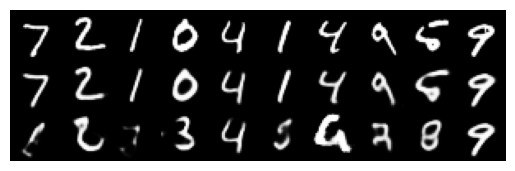

In [21]:
grid = make_grid(
    torch.cat([
        test_img,
        vae.decode(source_points),
        cf_opt_imgs,
    ], dim = 0), 
    nrow=10
)
img = ToPILImage()(grid)
plt.imshow(img)
plt.gca().set_axis_off()
plt.show()

## CGM-based

In [22]:
def cgm_cf(imgs, target_y, classifier, generator):
    source_y = classifier(imgs)
    embedding, _ = generator.encode(imgs, cond = source_y)
    return generator.decode(embedding, cond = target_y)

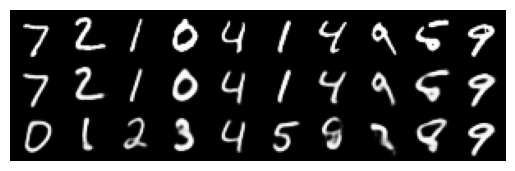

In [23]:
target_y = F.one_hot(torch.arange(10, device=device), 10)
cf_cgm_imgs = cgm_cf(test_img, target_y, lambda x: F.softmax(classifier(x), dim = 1), cvae)
grid = make_grid(
    torch.cat([
        test_img,
        vae.decode(source_points),
        cf_cgm_imgs
    ], dim = 0), 
    nrow=10
)
img = ToPILImage()(grid)
plt.imshow(img)
plt.gca().set_axis_off()
plt.show()

## Visualization

In [24]:
grid = make_grid(
    torch.cat([
        test_results[1],
        test_results[0],
        cf_opt_imgs,
        cf_cgm_imgs,
        cf_imgs,
        cf_robust_imgs,
    ], dim = 0), 
    nrow=10
)

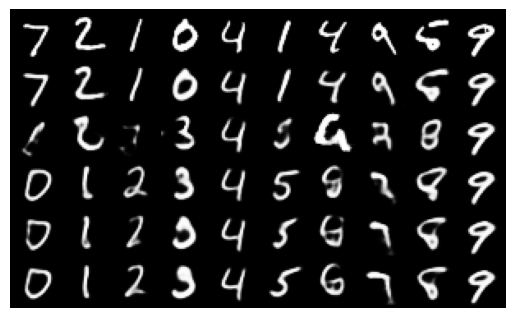

In [25]:
img = ToPILImage()(grid)
plt.imshow(img)
plt.gca().set_axis_off()
# plt.savefig('MorphoMNIST_plot.svg', bbox_inches='tight', dpi = 300)
plt.show()

## Quantatitive comparison

### Compare with baselines

In [26]:
metric_selection = {'area':0, 'length': 1, 'thickness': 2, 'slant': 3, 'width': 4, 'height': 5}
pool =  Pool(32)
chunksize = 16

morpho_test = {}
morpho_recon = {}
morpho_cf = {}
morpho_cf_robust = {}
morpho_cf_opt = {}
morpho_cf_cgm = {}
for metric_name in metric_selection:
    morpho_test[metric_name] = []
    morpho_recon[metric_name] = []
    morpho_cf[metric_name] = []
    morpho_cf_robust[metric_name] = []
    morpho_cf_opt[metric_name] = []
    morpho_cf_cgm[metric_name] = []
morpho_test = pd.DataFrame(morpho_test)
morpho_recon = pd.DataFrame(morpho_recon)
morpho_cf = pd.DataFrame(morpho_cf)
morpho_cf_robust = pd.DataFrame(morpho_cf_robust)
morpho_cf_opt = pd.DataFrame(morpho_cf_opt)
morpho_cf_cgm = pd.DataFrame(morpho_cf_cgm)

metric_acc_cf = MulticlassAccuracy()
metric_acc_cf_robust = MulticlassAccuracy()
metric_acc_cf_opt = MulticlassAccuracy()
metric_acc_cf_cgm = MulticlassAccuracy()
def update_acc(pred, label, metric):
    metric.update(torch.argmax(pred, dim = 1), torch.argmax(label, dim = 1))

metric_auc_cf = MulticlassAUROC(num_classes = 10)
metric_auc_cf_robust = MulticlassAUROC(num_classes = 10)
metric_auc_cf_opt = MulticlassAUROC(num_classes = 10)
metric_auc_cf_cgm = MulticlassAUROC(num_classes = 10)
def update_auc(pred, label, metric):
    metric.update(pred, torch.argmax(label, dim = 1))

In [27]:
# hyperparameter of opt-based
opt_lr = 0.2
opt_N = 1000
opt_sim_weight = 0.0006
# hyperparameter of leapfactual
n_steps = 5
# blending
N_b = 15
gamma_b = 0.1
# injection
N_i = 5
gamma_i = 0.1

In [28]:
for test_img, test_label in dataset.test_dataloader():
    # generate CF
    generator = lambda x: vae.decode(x, cond = None)
    classifier_softmax = lambda x: F.softmax(classifier(x), dim = 1)
    test_img = test_img.to(device)
    # test_label = F.one_hot(test_label.to(dtype = torch.int64, device=device)
    source_points, _ = vae.encode(test_img, cond = None)
    source_y = classifier_softmax(generator(source_points))
    target_y = F.one_hot(torch.randint(low = 0, high = 10, size = (test_img.shape[0], ), device=device), 10)
    recon_img = generator(source_points)
    traj_list = progressive_leap(model_cfm, source_points, classifier_softmax, generator, target_y,
                    gamma = gamma_b, max_itr = N_b, n_steps = n_steps, mode = 'blending', mute = True
                    )
    cf_img = generator(traj_list[-1])
    # generate robust CF
    source_points_robust = traj_list[-1]
    traj_list_robust = progressive_leap(model_cfm, source_points_robust, classifier_softmax, generator, target_y,
                    gamma = gamma_i, max_itr = N_i, n_steps = n_steps, mode = 'injection', mute = True
                    )
    cf_robust_img = generator(traj_list_robust[-1])
    # generate CF optimization
    cf_opt_img = optimize_cf(test_img, target_y, classifier_softmax, vae, optim_lr = opt_lr, max_itr = opt_N, sim_weight = opt_sim_weight)
    # generate CF CGM
    cf_cgm_img = cgm_cf(test_img, target_y, classifier_softmax, cvae)
    # measure morphology
    morpho_test_batch = dataset.test_dataset.measure_morpho_batch(test_img, pool = pool, chunksize = chunksize)
    morpho_recon_batch = dataset.test_dataset.measure_morpho_batch(recon_img, pool = pool, chunksize = chunksize)
    morpho_cf_batch = dataset.test_dataset.measure_morpho_batch(cf_img, pool = pool, chunksize = chunksize)
    morpho_cf_robust_batch = dataset.test_dataset.measure_morpho_batch(cf_robust_img, pool = pool, chunksize = chunksize)
    morpho_cf_opt_batch = dataset.test_dataset.measure_morpho_batch(cf_opt_img, pool = pool, chunksize = chunksize)
    morpho_cf_cgm_batch = dataset.test_dataset.measure_morpho_batch(cf_cgm_img, pool = pool, chunksize = chunksize)

    morpho_test = pd.concat([morpho_test, morpho_test_batch] , ignore_index=True)
    morpho_recon = pd.concat([morpho_recon, morpho_recon_batch] , ignore_index=True)
    morpho_cf = pd.concat([morpho_cf, morpho_cf_batch] , ignore_index=True)
    morpho_cf_robust = pd.concat([morpho_cf_robust, morpho_cf_robust_batch] , ignore_index=True)
    morpho_cf_opt = pd.concat([morpho_cf_opt, morpho_cf_opt_batch] , ignore_index=True)
    morpho_cf_cgm = pd.concat([morpho_cf_cgm, morpho_cf_cgm_batch] , ignore_index=True)

    # measure accuracy / auc
    pred_cf = classifier_softmax(cf_img)
    pred_cf_robust = classifier_softmax(cf_robust_img)
    pred_cf_opt = classifier_softmax(cf_opt_img)
    pred_cf_cgm = classifier_softmax(cf_cgm_img)

    update_acc(pred_cf, target_y, metric_acc_cf)
    update_acc(pred_cf_robust, target_y, metric_acc_cf_robust)
    update_acc(pred_cf_opt, target_y, metric_acc_cf_opt)
    update_acc(pred_cf_cgm, target_y, metric_acc_cf_cgm)

    update_auc(pred_cf, target_y, metric_auc_cf)
    update_auc(pred_cf_robust, target_y, metric_auc_cf_robust)
    update_auc(pred_cf_opt, target_y, metric_auc_cf_opt)
    update_auc(pred_cf_cgm, target_y, metric_auc_cf_cgm)

CLS_Loss = 0.0153, SIM_Loss = 0.0001, Loss = 0.0153: 100%|████████████████████████████████| 1000/1000 [00:10<00:00, 93.93it/s]
100%|#####################################################################################| 512/512 [00:00<00:00, 605.39img/s]
CLS_Loss = 0.0149, SIM_Loss = 0.0001, Loss = 0.0149: 100%|███████████████████████████████| 1000/1000 [00:08<00:00, 118.45it/s]
100%|#####################################################################################| 512/512 [00:00<00:00, 586.38img/s]
CLS_Loss = 0.0140, SIM_Loss = 0.0001, Loss = 0.0141: 100%|████████████████████████████████| 1000/1000 [00:10<00:00, 93.25it/s]
100%|#####################################################################################| 512/512 [00:00<00:00, 619.75img/s]
CLS_Loss = 0.0140, SIM_Loss = 0.0001, Loss = 0.0141: 100%|████████████████████████████████| 1000/1000 [00:10<00:00, 92.32it/s]
100%|#####################################################################################| 512/512 [00:00<00:0

In [29]:
for metric_name in metric_selection.keys():
    diff = ((morpho_recon[metric_name] - morpho_test[metric_name]) / morpho_test[metric_name]).abs()
    print(metric_name, diff.mean(), diff.sem())

area 0.030059255340833858 0.00030335108250198256
length 0.06670191855247455 0.0006568065606557738
thickness 0.06282350895244504 0.0005249660415183853
slant 0.4222774719352417 0.06522279891199018
width 0.01904263838221778 0.0002495959061885473
height 0.010808567925020376 0.00015357837437499628


In [30]:
morpho_dict = {'Opt-based': morpho_cf_opt, 'CGM_based': morpho_cf_cgm, 'LeapFactual': morpho_cf, 'LeapFactual_R': morpho_cf_robust}
final_df = pd.DataFrame(columns = morpho_dict.keys())
for name, acc, auc in zip(morpho_dict.keys(), 
                          [metric_acc_cf_opt.compute(), metric_acc_cf_cgm.compute(), metric_acc_cf.compute(), metric_acc_cf_robust.compute()],
                          [metric_auc_cf_opt.compute(), metric_auc_cf_cgm.compute(), metric_auc_cf.compute(), metric_auc_cf_robust.compute()],
                         ):
    final_df.loc['ACC', name] = "{:.4f}".format(acc.item())
    final_df.loc['AUC', name] = "{:.4f}".format(auc.item())
for name, morpho in morpho_dict.items():
    diff = ((morpho - morpho_recon) / morpho_recon).abs()
    mu = diff.mean().round(decimals=4).astype(str)
    mu.index.name = name
    std = (diff.sem()).round(decimals=4).astype(str)
    std.index.name = name
    df = pd.concat([mu,std],axis=0).groupby(name).agg(lambda mu_std: '±'.join(mu_std))
    for index, value in df.items():
        final_df.loc[index, name] = value

In [31]:
# final_df.to_csv('MorphoMNIST_comparison.csv')

In [32]:
final_df

,Opt-based,CGM_based,LeapFactual,LeapFactual_R
ACC,0.8784,0.9397,0.9877,0.9906
AUC,0.9152,0.9978,0.9993,1.0000
area,0.2359±0.0022,0.2479±0.0025,0.1658±0.0015,0.2159±0.0019
height,0.0613±0.0007,0.0275±0.0003,0.0278±0.0004,0.0315±0.0005
length,0.2499±0.0025,0.2965±0.0033,0.2049±0.002,0.262±0.0025
slant,3.6284±0.431,2.8908±0.5379,1.955±0.3442,2.1273±0.1786
thickness,0.1773±0.0017,0.0867±0.0007,0.0819±0.0008,0.0895±0.0008
width,0.2745±0.0041,0.3039±0.0049,0.1966±0.0028,0.2664±0.0038
